# Planet: Understanding the Amazon from Space

---

Use satellite data to track the human footprint in the Amazon rainforest

After Baseline Model

### 7. Improve model performance 

In the previous section, we defined a baseline model. The model achieved a reasonable F-beta score, although the learning curves suggested that the model had overfit the training dataset. 

Two common approaches to explore <B>to address overfitting</B> are <I>dropout regularization</I> and <I>data augmentation</I>. Both have the effect of disrupting and slowing down the learning process, specifically the rate that the model improves over training epochs.

Given that we expect the rate of learning to be slowed, we give the model more time to learn by increasing the number of training epochs from 50 to 200.

#### a. Dropout Regularization

A computationally cheap way to regularize a neural net.
It works by probabilistically removing inputs to layers, which may be input variables in the data sample or activations from a precious layer. 

define_model() has a dropout of 20% which is applied after each VGG block, with a larger dropout rate of 50% applied after the fully connected layer in the classifier part of the model. 

In [1]:
import sys 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras import backend 
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten 
from keras.layers import Dropout 
from keras.optimizers import SGD

Using TensorFlow backend.


In [3]:
def load_dataset():
    data = np.load('planet_data.npz')
    X,y = data['arr_0'], data['arr_1']
    trainX,testX,trainY,testY = train_test_split(X, y, test_size = 0.3, random_state=1)
    print(trainX.shape, trainY.shape, testX.shape, testY.shape)
    return trainX, trainY, testX, testY

In [4]:
def fbeta(y_true, y_pred, beta = 2):
    #clip predictions
    y_pred = backend.clip(y_pred, 0, 1)
    # calculate elements
    tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
    fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
    fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
    # calculate precision
    p = tp / (tp + fp + backend.epsilon())
    # calculate recall
    r = tp / (tp + fn + backend.epsilon())
    # calculate fbeta, averaged across each class
    bb = beta ** 2
    fbeta_score = backend.mean((1 + bb) * (p * r) / (bb * p + r + backend.epsilon()))
    return fbeta_score

In [5]:
# define cnn model
def define_model(in_shape=(128, 128, 3), out_shape=17):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=in_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.5))
    model.add(Dense(out_shape, activation='sigmoid'))
    # compile model
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fbeta])
    return model

In [6]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
    # plot loss
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    pyplot.subplot(212)
    pyplot.title('Fbeta')
    pyplot.plot(history.history['fbeta'], color='blue', label='train')
    pyplot.plot(history.history['val_fbeta'], color='orange', label='test')
    # save plot to file
    filename = sys.argv[0].split('/')[-1]
    pyplot.savefig(filename + '_plot.png')
    pyplot.close()

In [ ]:
# run the test harness for evaluating a model
def run_test_harness():
    # load dataset
    trainX, trainY, testX, testY = load_dataset()
    # create data generator
    datagen = ImageDataGenerator(rescale=1.0/255.0)
    # prepare iterators
    train_it = datagen.flow(trainX, trainY, batch_size=128)
    test_it = datagen.flow(testX, testY, batch_size=128)
    # define model
    model = define_model()
    # fit model
    history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
        validation_data=test_it, validation_steps=len(test_it), epochs=200, verbose=0)
    # evaluate model
    loss, fbeta = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
    print('> loss=%.3f, fbeta=%.3f' % (loss, fbeta))
    # learning curves
    summarize_diagnostics(history)
 
# entry point, run the test harness
run_test_harness()

In this case, we can see a small lift in model performance from an F-beta score of about 0.831 for the baseline model to about 0.859 with the addition of dropout.

Reviewing the learning curves, we can see that dropout has had some effect on the rate of improvement of the model on both the train and test sets

Overfitting has ben reduced or delayed, although the performance may begin to stall towards the middle of the run, around 100 epochs.

A larger dropout rate and/or perhaps the addition of weight decay. Additionally, the batch size could be decreased and the learning rate decreased, both of which may further slow the rate of improvement by the model, with a positive effect on reducing the overfitting the training dataset. 

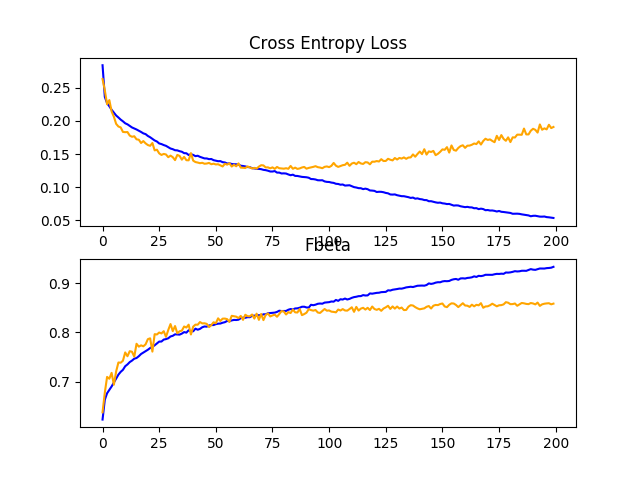

#### b. Image Data Augmentation

It is a technique that can be used to artifically expand the size of a training dataset by creating modified versions of images in the dataset. 

Data augmentation can also act as a regularization technique, adding noise to the training data and encouraging the model to learn the same features, invariant to their position in the input. 

Small changes to the input photos of the satellite photos might be useful for this problem, such as horizontal flips and more. 

Photos in the training dataset will be augmented with random horizontal and vertical flips as well as random rotations of up to 90 degrees. Photos in both the train and test steps will have their pixel values scaled in the same way as we did for the baseline model.

In [ ]:
# run the test harness for evaluating a model
def run_test_harness():
    # load dataset
    trainX, trainY, testX, testY = load_dataset()
    # create data generator
    train_datagen = ImageDataGenerator(rescale=1.0/255.0, horizontal_flip=True, vertical_flip=True, rotation_range=90)
    test_datagen = ImageDataGenerator(rescale=1.0/255.0)
    # prepare iterators
    train_it = train_datagen.flow(trainX, trainY, batch_size=128)
    test_it = test_datagen.flow(testX, testY, batch_size=128)
    # define model
    model = define_model()
    # fit model
    history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
        validation_data=test_it, validation_steps=len(test_it), epochs=200, verbose=0)
    # evaluate model
    loss, fbeta = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
    print('> loss=%.3f, fbeta=%.3f' % (loss, fbeta))
    # learning curves
    summarize_diagnostics(history)
 
# entry point, run the test harness
run_test_harness()

In this case, we can see a lift in performance of about 0.06 from an F-beta score of about 0.831 for the baseline model to a score of about 0.882 for the baseline model with simple data augmentation. This is a large improvement, larger than we saw with dropout.

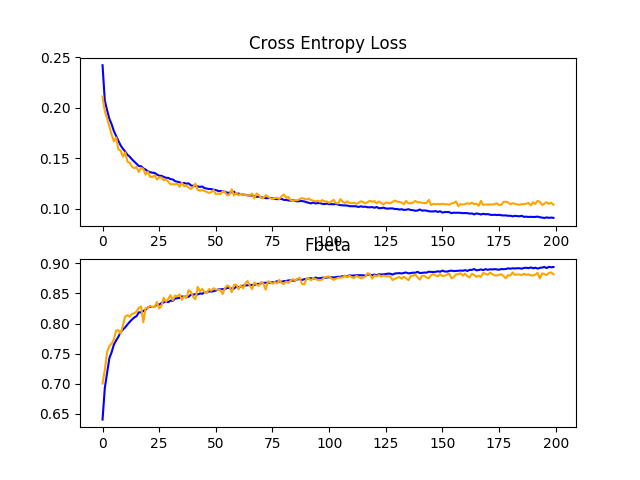

Learning continues well past 100 epochs. It may be interesting to explore additional image augmentations that may further encourage learning of features invariant to thier position in the input, such as zooms and shifts 

Regularization techniques slows the progression of the learning algorithms and reduces overfitting, resulting in improved performance on the holdout dataset.

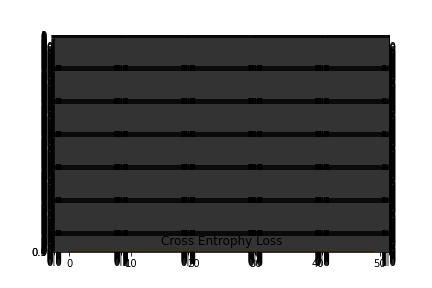